In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [9]:
# importing sklearn models and metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, cohen_kappa_score, f1_score, classification_report, balanced_accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler


# Supervised Machine Learning


This section will give a brief overview of a couple of supervised machine learning methods.

(You'll want to look at the slides for additional information on how to approach these questions.)

<h2 style="color:red;font-weight:bold">Question 1 </h2>

<span style="color:red;font-weight:bold">Train two models using data from the 2020 election to predict Democratic party vote share. Evaluate your results using the 2024 election results. Assess the results using the `mean_squared_error` and `r2_score`</span>

In [5]:
election_data = pd.read_csv("election_data.csv")


<h2 style="color:red;font-weight:bold"> Question 2 </h2>

<span style='color:red;font-weight:bold'>Create two models to predict whether a country experienced a terrorist attack in 2020. Evaluate your results on a random sample of held-out data. Examine the confusion matrix, and use `cohens_kappa_score`, `balanced_accuracy_score` to compare your results.</span>

In [6]:
gtd = pd.read_csv("gtd_data.csv")


# Extra code

### Using a pipeline

Pipelines are a way to ensure consistent pre-processing on the training and testing data. You can write a pipeline by using the `Pipeline` function and passing a list of tuples with a set of processing steps and a final estimator.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

gtd = pd.read_csv("gtd_data.csv")
gtd_dummified = pd.get_dummies(gtd, columns=['any_attacks','any_attacks_prior_year', 'autonomy'],  
                            drop_first=True, dtype='int')
gtd_features = gtd_dummified[['gdp_pcap', 'oil', 'liberal_democracy','political_stability', 'population']]
gtd_outcome = gtd_dummified['any_attacks_yes']

train_X, test_X, train_y, test_y = train_test_split(gtd_features,
                                                    gtd_outcome,
                                                    test_size=0.30,
                                                    random_state=20)

C:\Users\neilb\AppData\Local\Temp\ipykernel_33308\1811181307.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


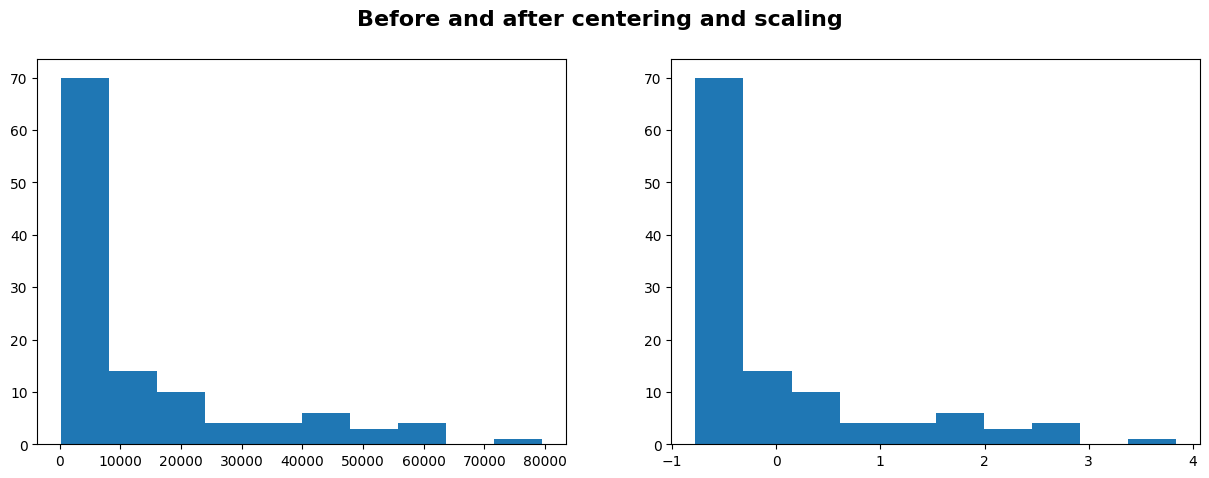

In [17]:



# Scaling predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_X)
X_test_scaled = scaler.transform(test_X)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(train_X.iloc[:,0])
axes[1].hist(X_train_scaled[:,0])
fig.suptitle('Before and after centering and scaling', fontsize=16, fontweight='bold')
fig.show()






For instance, here's a pipeline for a model that standardizes the features and applies [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) before using a logistic regression model to predict some outcome:

In [19]:
logit_pipe = Pipeline(
    steps  = [
        ('scale', StandardScaler()),
        ('pca', PCA()),
        ('logit_model', LogisticRegression())
         ]
    )


Now calling `fit` will apply the pre-processing steps and run the regression model:

In [20]:
logit_pipe.fit(train_X, train_y)


,steps,"[('scale', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'


And then calling `predict` will automatically apply those same pre-processing steps to new input data:

In [21]:
y_preds = logit_pipe.predict(test_X)


Now we'll check out the performance:

In [22]:
balanced_accuracy_score(y_preds, test_y)

0.7539184952978057

Where this really becomes useful is in cases where we have a complicated set of transformations that need to be applied to the data. For instance, I've got a mixture of categorical and numeric variables that require different kinds of processing steps before I use them in a model. I can make a single pipeline that applies the appropriate methods to each input and spits out a prediction all in one step:

In [23]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
positive_numeric_prep = Pipeline(
    steps=[
        ("power_transform", PowerTransformer(method='box-cox'))
    ]
)
categorical_prep= Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop='first'))
    ]
)
numeric_prep = Pipeline(
    steps=[
         ("transform", PowerTransformer(method='yeo-johnson'))
    ]
)
preprocessor = ColumnTransformer(
    [
        ("categorical features", categorical_prep, ["autonomy", 'any_attacks_prior_year']),
        ("numeric features >0", positive_numeric_prep, ["gdp_pcap",  "population", "life_expectancy"]),
        ("all other numeric features", numeric_prep, ["liberal_democracy", "political_stability","resource_rents", "oil"]),
    ]
)
logit_pipe = make_pipeline(preprocessor,
                           LogisticRegression(C = 3))

logit_pipe


,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical features', ...), ('numeric features >0', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [24]:
X = gtd[[ 'autonomy', 'gdp_pcap', 'population', 'liberal_democracy','political_stability', "resource_rents", "oil", "life_expectancy", 'any_attacks_prior_year']] # list of inputs
y = pd.get_dummies(gtd['any_attacks'], drop_first=True, dtype='int').iloc[:, 0]                                                                                   # making a 1/0 encoded version of the terrorist attacks variable
train_X, test_X, train_y, test_y = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=20)


Fit the model with the training data:


In [25]:
logit_pipe.fit(train_X, train_y)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical features', ...), ('numeric features >0', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


We can still use the `.predict` method with the fitted pipeline to get a prediction for new data, the difference is that the pre-processing steps are automatically applied to the new data:

In [26]:
y_preds = logit_pipe.predict(test_X)
balanced_accuracy_score(y_preds, test_y)

0.823076923076923

## Cross-validation methods

In the previous examples we used a single training/testing split to train and evaluate a model. But how do we know that our model performance isn't just a matter of luck? Maybe our testing data, by sheer chance

In [36]:
from sklearn.model_selection import cross_validate, KFold

kf = KFold(n_splits=10, shuffle=True, random_state=199)


scores = cross_validate(logit_pipe, X, y, cv=kf,
                        scoring=('accuracy',
                                 'balanced_accuracy', 
                                 'precision', 
                                 'recall'),
                        return_train_score=True)



c:\Users\neilb\Documents\UMD\BSOS326\BSOS326Fall2025\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [29]:
pd.DataFrame(scores).describe()

,fit_time,score_time,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy,test_precision,train_precision,test_recall,train_recall
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.052336,0.009820,0.816912,0.840340,0.816365,0.837817,0.843001,0.828294,0.787302,0.813382
std,0.006837,0.005472,0.133537,0.011408,0.133816,0.011402,0.181484,0.014286,0.151770,0.017895
min,0.045073,0.007354,0.588235,0.827815,0.590278,0.825380,0.555556,0.808824,0.571429,0.787879
25%,0.046475,0.007573,0.735294,0.833609,0.732887,0.831300,0.678571,0.818860,0.666667,0.800032
50%,0.052069,0.008097,0.823529,0.840000,0.829545,0.837662,0.928571,0.823491,0.805556,0.813503
75%,0.053813,0.008481,0.923713,0.845000,0.918651,0.840018,1.000000,0.833333,0.870536,0.820217
max,0.064894,0.025230,1.000000,0.866667,1.000000,0.865132,1.000000,0.852459,1.000000,0.850746


In [30]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

pipelines = {
    "dummy model": Pipeline(
        steps  = [
            ('scaler', StandardScaler()), 
            ('power_transform', PowerTransformer(method='yeo-johnson')),
            ('dummy_model', DummyClassifier(strategy = 'prior'))
            ]
    ),
    "naive bayes" : Pipeline(
        steps  = [
            ('scaler', StandardScaler()), 
            ('power_transform', PowerTransformer(method='yeo-johnson')),
            ('nb_model', GaussianNB())
            ]
        ),

    "kernel svm" : Pipeline(
        steps  = [
            ('scaler', StandardScaler()), 
            ('power_transform', PowerTransformer(method='yeo-johnson')),
            ('svm_model', SVC(kernel='rbf', C=1, gamma='scale'))
            ]
        ),
    "logistic" : Pipeline(
        steps  = [
            ('scaler', StandardScaler()), 
            ('power_transform', PowerTransformer(method='yeo-johnson')),
            ('logit_model', LogisticRegression(random_state=12, C=1))
            ]
        )
}


In [31]:
from sklearn.model_selection import RepeatedKFold
kf = RepeatedKFold(n_splits=5, n_repeats=50,  random_state=199)

scorelist = {}
for key, value in pipelines.items():
    scores = cross_validate(value, gtd_features, gtd_outcome, cv=kf,
                        scoring=('accuracy',
                                 'balanced_accuracy'))
    scorelist[key] = scores



In [32]:

metrics = pd.concat({key:pd.DataFrame(value) for key, value in scorelist.items()}).reset_index(names = ['model', 'iteration'])
metrics.head()

,model,iteration,fit_time,score_time,test_accuracy,test_balanced_accuracy
0,dummy model,0,0.009432,0.002246,0.470588,0.5
1,dummy model,1,0.007777,0.002312,0.558824,0.5
2,dummy model,2,0.010211,0.003064,0.575758,0.5
3,dummy model,3,0.008365,0.002460,0.545455,0.5
4,dummy model,4,0.009528,0.003834,0.606061,0.5


In [33]:
median_order = metrics.groupby('model')['test_balanced_accuracy'].median().sort_values().index

Text(0, 0.5, 'Balanced Accuracy')

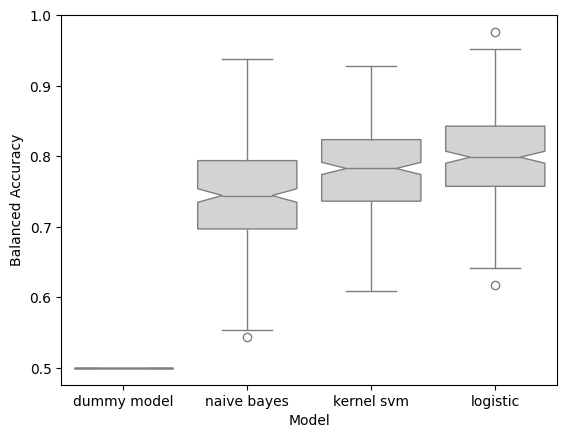

In [694]:
import seaborn as sns

ax = sns.boxplot(x= 'model', 
            y='test_balanced_accuracy' ,
            color='lightgrey', 
            data = metrics,
            order = median_order,
            notch=True
            )
ax.set_xlabel("Model")
ax.set_ylabel("Balanced Accuracy")

In [34]:
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue  = permutation_test_score(pipelines['logistic'], gtd_features, gtd_outcome)

Original Score: 0.808
Permutation Scores: 0.529 +/- 0.035
p.value = 0.010


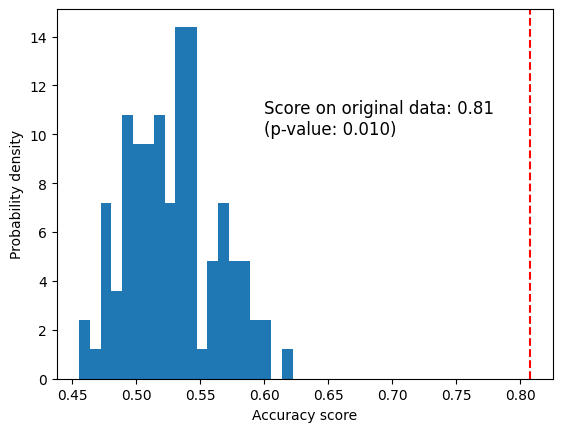

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(permutation_scores, bins=20, density=True)
ax.axvline(score, ls="--", color="r")
score_label = (
    f"Score on original data: {score:.2f}\n(p-value: {pvalue:.3f})"
)
ax.text(0.6, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability density")

print(f"Original Score: {score:.3f}")
print(
    f"Permutation Scores: {permutation_scores.mean():.3f} +/- "
    f"{permutation_scores.std():.3f}"
)
print(f"p.value = {pvalue:.3f}")

In [923]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

election_data = pd.read_csv("election_data.csv")

# 1. select predictors/outcome ----

features = ['num_households','mean_income', 'percent_bachelors']
outcome = ['per_dem']
X = election_data[features]
y = election_data[outcome]

# 2. Split data ------

train_index = election_data['year'] == 2020
test_index  = election_data['year'] == 2024
# training data
X_train = X.loc[train_index]
y_train = y.loc[train_index]

# testing data
X_test = X.loc[test_index]
y_test = y.loc[test_index]

## 3. Pre-process -----

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Fit model on training data ----

model = LinearRegression().fit(X_train_scaled, y_train)

# 5. Assess model fit ----

y_pred = model.predict(X_test_scaled)


# getting predictions for 2024:
y_pred = model.predict(X_test_scaled)



print("MSE:", mean_squared_error(y_test, y_pred),
      "\nR^2:" , r2_score(y_test, y_pred)
)


MSE: 0.015942709294787957 
R^2: 0.3407111812314363


In [ ]:
ct = ColumnTransformer(
    [
     ("scaled", StandardScaler(), ['mean_income', 'percent_bachelors']),
     ('power_transformed', PowerTransformer(method = 'yeo-johnson'), ['num_households'])
     ]
     )
X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)

model = LinearRegression().fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)


# getting predictions for 2024:
y_pred = model.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred),
      "\nR^2:" , r2_score(y_test, y_pred)
)



MSE: 0.01460302522496852 
R^2: 0.3961119736301957


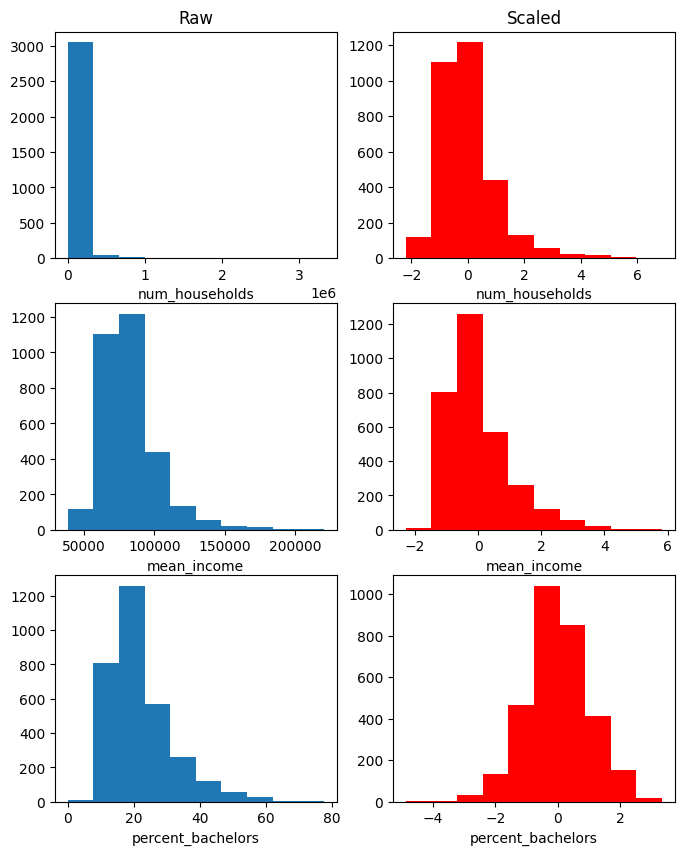

In [953]:
cols = X_train_scaled.shape[1]
fig, axes = plt.subplots(cols, 2, figsize=(8, 10))
axes[0,0].set_title("Raw")
axes[0,1].set_title("Scaled")
for i in range(cols):
    axes[i,0].hist(X_train.iloc[:,i])
    axes[i,1].hist(X_train_scaled[:,i], color='red')

    axes[i,1].set_xlabel(features[i])
    axes[i,0].set_xlabel(features[i])

plt.show()


In [882]:
import plotly.express as px
pred_df = pd.DataFrame(X_test, columns=features)
pred_df['outcome'] = y_test
pred_df['prediction']  = y_pred
pred_df['county'] = election_data.loc[test_index, 'county'] + ", " +election_data.loc[test_index, 'state']
pred_df['winner'] = np.where(pred_df['outcome']>=.5, "Dem.", "Rep.")
pred_df['sqrt_households'] = np.sqrt(pred_df['num_households'])
pred_df.head()

,num_households,mean_income,percent_bachelors,outcome,prediction,county,winner,sqrt_households
0,22523.0,109137,28.3,0.263888,0.332932,"Autauga County, Alabama",Rep.,150.076647
1,94642.0,119421,32.8,0.204699,0.383589,"Baldwin County, Alabama",Rep.,307.639399
2,9080.0,77821,11.5,0.422905,0.201181,"Barbour County, Alabama",Rep.,95.289034
3,7571.0,79298,11.5,0.175197,0.197961,"Bibb County, Alabama",Rep.,87.011493
4,21977.0,91220,15.6,0.091624,0.225075,"Blount County, Alabama",Rep.,148.246416


In [911]:

fig = px.scatter(pred_df,
                  x='prediction', 
                  y='outcome',
                  hover_name = 'county',
                  custom_data= ['county', 'num_households', 'mean_income', 'percent_bachelors'],
                  size   = 'sqrt_households',
                  color  = 'winner',
                  color_discrete_map={'Dem.': "royalblue", "Rep.":"red"},
                  width  = 700,
                  height = 700,
                  )
fig.update_traces(hovertemplate='<br>'.join([
                                "<b style='font-size: 16px;'>%{customdata[0]}</b>",
                                "<b>Predicted D. vote</b>: %{x:.1%}",
                                "<b>Actual D. vote</b>: %{y:.1%}",
                                "<b>Num. households:</b> %{customdata[1]:,.0f}",
                                "<b>Mean income:</b> $%{customdata[2]:,.0f}", 
                                "<b>Perc. Bachelor's:</b> %%{customdata[3]}"
                                ])
                )
fig.update_layout(
    xaxis_range=[0, 1.35],  # Sets x-axis range
    yaxis_range=[0, 1.35]   # Sets y-axis range
)
fig.add_shape(type="line",
              x0=0, y0=0, x1=1.4, y1=1.4,
              line=dict(color="grey", width=2))
fig.show()


In [920]:
pred_df['log_num_households']  = np.log(pred_df['num_households'])

fig = px.scatter(pred_df,
                  x='num_households', 
                  y='outcome',
                  hover_name = 'county',
                  custom_data= ['county', 'num_households', 'mean_income', 'percent_bachelors', 'outcome', 'prediction'],
                  size   = 'sqrt_households',
                  color  = 'winner',
                 color_discrete_map={'Dem.': "royalblue", "Rep.":"red"},
                  width  = 500,
                  height = 500,
                  )
fig.update_traces(mode='markers', hovertemplate='<br>'.join([
                                "<b style='font-size: 16px;'>%{customdata[0]}</b>",
                                "<b>Predicted D. vote</b>: %{customdata[5]:.1%}",
                                "<b>Actual D. vote</b>: %{customdata[4]:.1%}",
                                "<b>Num. households:</b> %{customdata[1]:,.0f}",
                                "<b>Mean income:</b> $%{customdata[2]:,.0f}", 
                                "<b>Perc. Bachelor's:</b> %%{customdata[3]}"
                                ])
                )
fig.update_layout(xaxis_title="Number of households")
fig.show()


In [956]:
election_data.columns

Index(['Unnamed: 0', 'county', 'num_households', 'mean_income',
       'percent_employed', 'percent_bachelors', 'percent_graduate',
       'state_code', 'county_code', 'state', 'county_fips', 'state_name',
       'county_name', 'votes_gop', 'votes_dem', 'total_votes', 'diff',
       'per_gop', 'per_dem', 'per_point_diff', 'year'],
      dtype='object')